In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# 11_2_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/11_2_LEARN_DataAnalysisML.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We can import the data repository like this: 

In [2]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 0. Intro

This is the second notebook showcasing how we can use machine learning techniques to predict the best promoter-gene combinations. We will use various machine learning algorithms through the package H2O. We continue the workflow by using Machine Learning to predict the best promoter:gene combinations of the remaining library that was generated in [09_2_BUILD_CombinatorialLibrary](../colab_notebooks/09_2_BUILD_CombinatorialLibrary.ipynb) and analyzed in [10_2_TEST_Library_Characterization](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb). 

What is different in this notebook is that we investigate how the ML faired in predicting strictosidine values and we compare how a ML model trained on two rounds of data differ from the one we used in notebook [07_1_LEARN_DataAnalysis](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb)


## Project overview - Use ML to predicte best promoter:gene combinations 

**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

**2nd library**

Tasks
1. dgRNA
2. Base strain
3. Library
4. Phenotyping
**5. Machine Learning**
   - Predict the best promoter:gene combinations


## 1. Setup H2O AutoML

In [3]:
%%capture 
!pip install h2o

In [4]:
import h2o
from h2o.automl import H2OAutoML

In [5]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 52 mins
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,6 months and 18 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_cln7e2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.270 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [6]:
first_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
first_input_for_ml 

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.922793
1,yp49_C01,1,2,5,9,0.509123
2,yp49_D01,2,4,7,3,0.166871
3,yp49_E01,2,1,5,7,0.327489
4,yp49_F01,3,3,6,1,25.060934
...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000
163,yp51_D12,8,2,7,6,0.591185
164,yp51_E12,8,1,6,10,0.448644
165,yp50_F05,6,1,8,2,13.391244


### 1.2 Investigate how the predictions from the previous ML cycle matched the sampled strains 

In [7]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml = second_input_for_ml[['Line_name', '0','1','2','3','norm_strict_%']]
second_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

In [8]:
list_of_promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]

pg8h_list_of_index = ['CYC1', 'ENO2']
pcpr_list_of_index = ['CCW12', 'TPI1'] 


g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_input_for_ml['G8H'] = g8h_genotype
second_input_for_ml['CPR'] = cpr_genotype
second_input_for_ml['pG8H'] = pg8h_genotype
second_input_for_ml['pCPR'] = pcpr_genotype
second_input_for_ml

,Line_name,0,1,2,3,Amt_norm,G8H,CPR,pG8H,pCPR
0,yp53_A01,4,1,5,2,9.058562,Vmin,Aan,CYC1,CCW12
1,yp53_A02,4,1,5,2,28.175952,Vmin,Aan,CYC1,CCW12
2,yp53_A04,4,2,5,2,80.375862,Vmin,Aan,ENO2,CCW12
3,yp53_A06,5,1,5,2,121.767572,Smus,Aan,CYC1,CCW12
4,yp53_A07,5,2,6,2,159.059724,Smus,Aan,ENO2,TPI1
...,...,...,...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951,Vmin,Cro,CYC1,TPI1
125,yp54_C04,5,2,6,3,94.318358,Smus,Ara,ENO2,TPI1
126,yp54_C09,3,1,6,3,46.469517,Cro,Ara,CYC1,TPI1
127,yp54_D12,5,1,6,6,3.718051,Smus,Ahu,CYC1,TPI1


In [9]:
second_input_for_ml["Names"] = second_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
second_input_for_ml =second_input_for_ml[['Names', 'Amt_norm', 'Line_name']]
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [10]:
first_round_top_producers = pd.read_csv('G8H_CPR_library/data/09-AutoML/Top20_predictions/first_round/top20_ML_predicted_after_first_DBTL_1st_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Predicted_strict_production', ascending=False)

first_round_top_producers["Names"] = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
first_round_top_producers  = first_round_top_producers[['Names', 'Predicted_strict_production']]
first_round_top_producers['Predicted_strict_production_rank_pct']= first_round_top_producers['Predicted_strict_production'].rank(pct=True)
first_round_top_producers

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct
0,Smus-ENO2-TPI1-Rse,169.288180,1.000000
1,Rsep-ENO2-TPI1-Ara,162.151856,0.999106
2,Smus-ENO2-CCW12-Ara,161.904255,0.998213
3,Smus-CYC1-TPI1-Ara,157.638727,0.997319
4,Smus-ENO2-TPI1-Aan,156.976470,0.996425
...,...,...,...
1114,Rsep-CYC1-TPI1-Ani,-9.125477,0.004468
1115,Ccal-ENO2-TPI1-Cac,-12.768510,0.003575
1116,Rsep-PCK1-CCW12-Ara,-12.901417,0.002681
1117,Ccal-ENO2-CCW12-Cac,-16.241411,0.001787


In [11]:
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [12]:
## merging the unsampled library with the second sampling
predicted_vs_sampled = pd.merge(first_round_top_producers, second_input_for_ml, on=['Names'])
predicted_vs_sampled['norm_strict_measured_rank'] = predicted_vs_sampled['Amt_norm'].rank(pct=True)
predicted_vs_sampled['Predicted_strict_production_rank_pct'] = predicted_vs_sampled['Predicted_strict_production'].rank(pct=True)

predicted_vs_sampled = predicted_vs_sampled.sort_values(by= 'Amt_norm', ascending = False)


In [13]:
predicted_vs_sampled

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct,Amt_norm,Line_name,norm_strict_measured_rank
0,Smus-ENO2-TPI1-Rse,169.288180,0.995575,169.631396,yp53_D09,1.000000
10,Rsep-ENO2-TPI1-Clo,103.496648,0.907080,159.517718,yp53_C06,0.991150
4,Smus-ENO2-TPI1-Aan,156.976470,0.964602,159.059724,yp53_A07,0.982301
31,Smus-CYC1-CCW12-Clo,57.162466,0.725664,143.483630,yp53_C01,0.973451
32,Cro-ENO2-TPI1-Cro,56.438602,0.712389,138.267757,yp54_B01,0.964602
...,...,...,...,...,...,...
99,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D10,0.061947
98,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D09,0.061947
97,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G04,0.061947
96,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G03,0.061947


In [14]:
from constrain.plotting.plotting import correlation_plot
correlation_plot

<function constrain.plotting.plotting.correlation_plot(dataframe, x: str, y: str, save_pdf=True, path='', size_height: int = 10, size_length: int = 10) -> None>

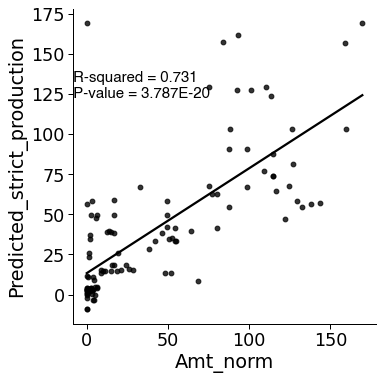

In [15]:
correlation_plot(predicted_vs_sampled,"Amt_norm","Predicted_strict_production", size_height= 5, size_length = 5)

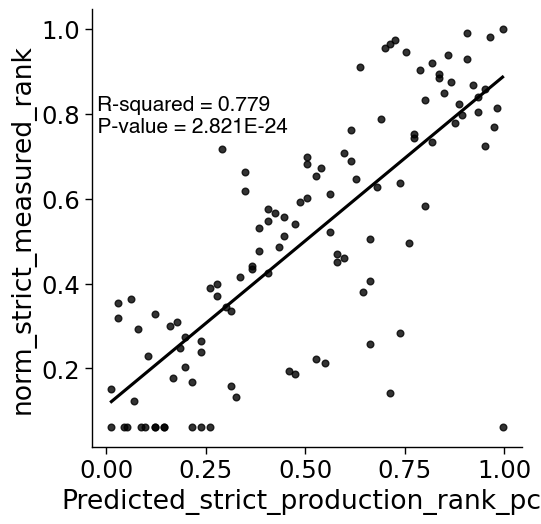

In [16]:
correlation_plot(predicted_vs_sampled,"Predicted_strict_production_rank_pct","norm_strict_measured_rank",size_height= 5, size_length = 5)

### 1.3 Merging the dataframes for updating the model 

In [17]:
first_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
second_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

We can add the first dataframe to the second. See below: 

In [18]:
new_input_for_ml = pd.concat([first_input_for_ml, second_input_for_ml])
new_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']
new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.922793
1,yp49_C01,1,2,5,9,0.509123
2,yp49_D01,2,4,7,3,0.166871
3,yp49_E01,2,1,5,7,0.327489
4,yp49_F01,3,3,6,1,25.060934
...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951
125,yp54_C04,5,2,6,3,94.318358
126,yp54_C09,3,1,6,3,46.469517
127,yp54_D12,5,1,6,6,3.718051


### 1.4 Update dataframe Change 

In [19]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:296
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.773648648648647,2.1452702702702697,6.135135135135138,4.750000000000003,28.172298324091862
maxs,NaN,8.0,4.0,8.0,10.0,245.03427469317091
sigma,NaN,1.946604570553522,1.115003045338059,1.0554051268004114,2.5930153901508803,44.45848009052247
zeros,0,0,0,0,0,72
missing,0,0,0,0,0,0
0,yp49_A01,1.0,2.0,5.0,1.0,0.9227925961906795
1,yp49_C01,1.0,2.0,5.0,9.0,0.5091231905250453
2,yp49_D01,2.0,4.0,7.0,3.0,0.166870967337397


In [20]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [21]:
df_test.describe()

Rows:296
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,28.172298324091862
maxs,NaN,,,,,245.03427469317091
sigma,NaN,,,,,44.45848009052247
zeros,0,,,,,72
missing,0,0,0,0,0,0
0,yp49_A01,1,2,5,1,0.9227925961906795
1,yp49_C01,1,2,5,9,0.5091231905250453
2,yp49_D01,2,4,7,3,0.166870967337397


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


### 1.5 If you dont want to run the AutoML skip the following paragraphs and go to paragraph 4.

## 2. RUN automl

Here we are defining the autoML object and after we can train it

In [ ]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    sort_metric = "MAE",
    #exclude_algos = ["StackedEnsemble"], # Stacked ensemble cannot perform CV-holdout_predictions
    keep_cross_validation_predictions=True,
    keep_cross_validation_models = True,
    keep_cross_validation_fold_assignment = True, 
)

Train a model based on the target and the df. 

In [ ]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 )

In [ ]:
print('DOOOOOOONE')

## 3. Processing model . i.e. saving the best model and the leaderboard. 


In [ ]:
## Saving the leaderboard ids
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])


In [ ]:
# how to save any model
out_path = 'G8H_CPR_library/data/09-AutoML/best_models/second_round/'
mdl = h2o.get_model(model_ids[1])
h2o.save_model(model=mdl, path=out_path, force=True)


In [ ]:
len(model_ids)

Now we want to extract the best models

In [ ]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

### 3.1 Saving the best model

In [ ]:
best_model = AutoML.get_best_model()
best_model

In [ ]:
model_path = h2o.save_model(model=best_model, path="G8H_CPR_library/data/09-AutoML/best_models/second_round/", force=True)

### 3.2 Exporting the leaderboard

In [ ]:
# saving the leaderboard

out_path = 'G8H_CPR_library/data/09-AutoML/leaderboards/second_round/'
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

### 3.3 saving the CV-holdout predictions 


In [ ]:
# Get the predictions
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()

# make the df_test to a dataframe
as_data_frame_df_test = df_test.as_data_frame()

# Make cv_pred to a dataframe
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()
as_data_frame_CV_predictions.columns = ['cv_holdout_predictions']
as_data_frame_CV_predictions

In [ ]:
# merge with the test dataframe
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
df3 = df3.reset_index()
df3['ranked_pct'] = df3['Amt_norm'].rank(pct= True)
df3['cv_holdout_predictions_ranked_pct'] = df3['cv_holdout_predictions'].rank(pct= True)
df3

In [ ]:
# save it to the folder
df3.to_csv('G8H_CPR_library/data/09-AutoML/cv_holdout_predictions/second_round/cv_holdout_predictions.csv')

## 4. Importing the best model 

If you didnt have time to run the model you can start from here and import it. 

Start by importing the leaderboard

In [23]:
leaderboard_path = 'G8H_CPR_library/data/09-AutoML/leaderboards/second_round/'
lb = h2o.import_file(path=os.path.join(leaderboard_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_5_AutoML_2_20230127_102838,11.7432,22.6591,513.437,0.925034,513.437
XGBoost_grid_1_AutoML_2_20230127_102838_model_292,11.9715,23.1744,537.051,nan,537.051
XGBoost_grid_1_AutoML_2_20230127_102838_model_165,12.1231,23.7071,562.027,nan,562.027
StackedEnsemble_BestOfFamily_6_AutoML_2_20230127_102838,12.2723,22.9134,525.023,nan,525.023
StackedEnsemble_BestOfFamily_4_AutoML_2_20230127_102838,12.3157,23.0186,529.856,nan,529.856
StackedEnsemble_AllModels_5_AutoML_2_20230127_102838,12.3774,22.5326,507.717,0.899211,507.717
XGBoost_grid_1_AutoML_2_20230127_102838_model_131,12.6166,23.8032,566.592,nan,566.592
StackedEnsemble_AllModels_6_AutoML_2_20230127_102838,12.7678,23.1745,537.059,nan,537.059
XGBoost_grid_1_AutoML_2_20230127_102838_model_886,13.1167,23.9121,571.788,nan,571.788
DeepLearning_grid_1_AutoML_2_20230127_102838_model_38,13.2159,23.2419,540.185,nan,540.185


Then the best model 

In [24]:
best_model = h2o.load_model("G8H_CPR_library/data/09-AutoML/best_models/second_round/"+lb[0,0])
my_local_model = h2o.download_model(best_model, path="G8H_CPR_library/data/09-AutoML/best_models/second_round/")
uploaded_model = h2o.upload_model(my_local_model)

### 4.1 Investigate model

In [25]:
best_model.cross_validation_metrics_summary

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_5_AutoML_2_20230127_102838

No model summary for this model

ModelMetricsRegression: stackedensemble
** Reported on train data. **

MSE: 441.3053460528196
RMSE: 21.007268886097965
MAE: 10.154367128079501
RMSLE: NaN
Mean Residual Deviance: 441.3053460528196

ModelMetricsRegression: stackedensemble
** Reported on cross-validation data. **

MSE: 513.4369519013621
RMSE: 22.659147201546713
MAE: 11.743164600229056
RMSLE: 0.9250338031860638
Mean Residual Deviance: 513.4369519013621

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,11.703684,4.442786,6.429022,16.639383,7.172491,12.942241,10.746461,20.196707,14.376469,7.602001,11.753926,9.178139
1,mean_residual_deviance,493.648380,335.834080,140.959810,1052.889500,142.954100,457.699130,317.863130,971.244300,595.644300,242.703310,753.125100,261.400970
2,mse,493.648380,335.834080,140.959810,1052.889500,142.954100,457.699130,317.863130,971.244300,595.644300,242.703310,753.125100,261.400970
3,r2,0.762723,0.097135,0.837538,0.590063,0.897149,0.743029,0.748879,0.631643,0.732788,0.849743,0.761522,0.834881
4,residual_deviance,493.648380,335.834080,140.959810,1052.889500,142.954100,457.699130,317.863130,971.244300,595.644300,242.703310,753.125100,261.400970
5,rmse,21.026045,7.568487,11.872650,32.448260,11.956342,21.393904,17.828716,31.164793,24.405825,15.578938,27.443125,16.167900
6,rmsle,0.898027,0.266623,0.839868,0.967022,0.876860,1.034826,0.952978,1.535413,0.768229,0.803330,0.581038,0.620705


<bound method ModelBase.cross_validation_metrics_summary of >

Get the cross validation predictions

In [26]:
# import the cross validated dataframe 
df3 = pd.read_csv('G8H_CPR_library/data/09-AutoML/cv_holdout_predictions/second_round/cv_holdout_predictions.csv')

### 4.2 Plotting the CV-holdout predictions agains the measured values per sample. 

In [27]:
from constrain.plotting.plotting import bar_plot_w_hue

In [28]:
%%capture
# initialing the sampled strictosidine values 
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']

# intializing the holdout_predictions
ds2 = df3[['Line_name', 'cv_holdout_predictions']]
ds2.columns = ['Line_name', 'strict']

# add category
ds2['category'] = 'CV_holdout_predictions'
ds1['category'] = 'strictosidine'
dss = pd.concat([ds1, ds2])

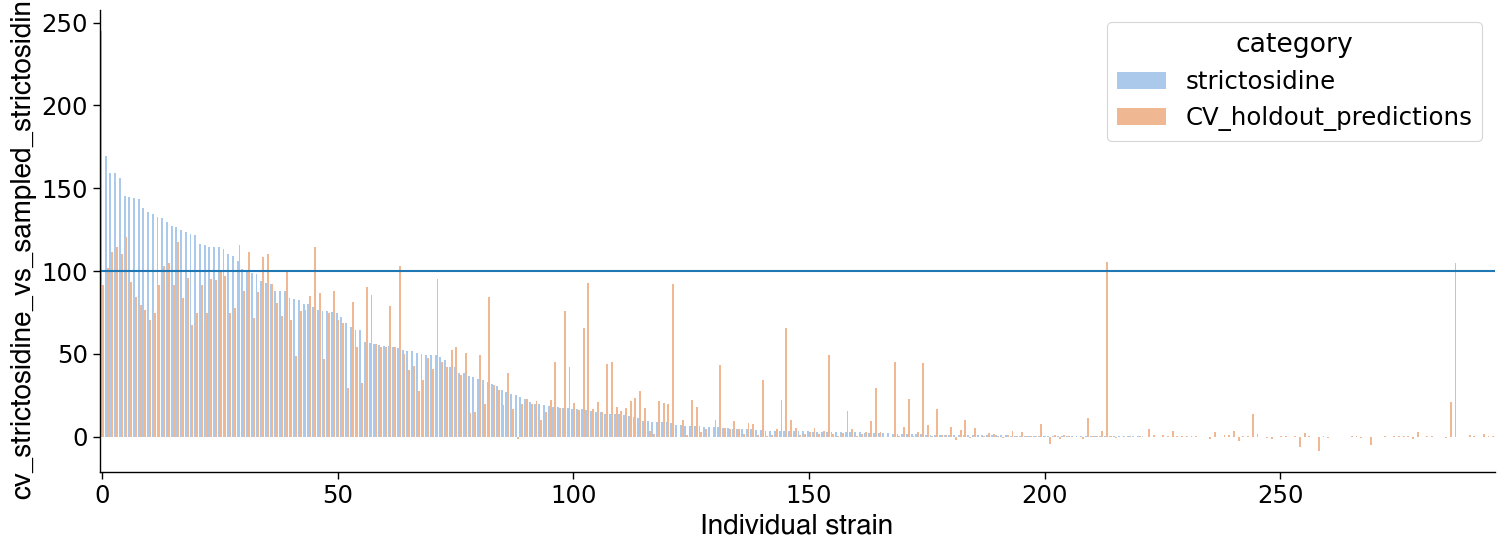

In [29]:
bar_plot_w_hue(dss, 'Line_name', 'strict', path = '', #G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/Bar_plot_prediction_vs_the_sampled_library
              x_label = 'Individual strain',
               hue = 'category',
               palette = 'pastel',
               y_label= 'cv_strictosidine_vs_sampled_strictosidine', 
                size_height = 6,
                size_length = 18
              )

#### CV-Holdout predictions vs measured correlation plot

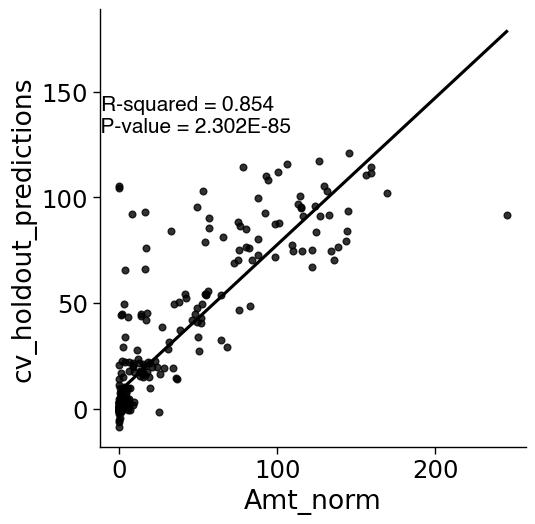

In [30]:
correlation_plot(df3,"Amt_norm","cv_holdout_predictions", 
                size_height = 5, 
                size_length= 5)

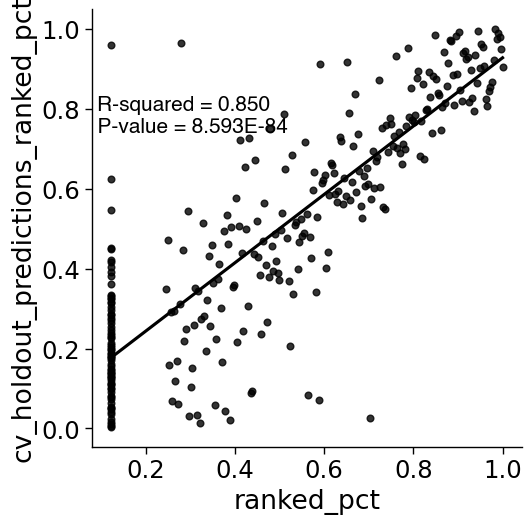

In [31]:
correlation_plot(df3,"ranked_pct","cv_holdout_predictions_ranked_pct",
                size_height = 5, 
                size_length= 5)

### 4.3 Find predicted genotypes

In [32]:
import numpy as np

In [33]:
all_genotypes = pd.read_csv('G8H_CPR_library/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [34]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,4
1,1,5,5
1,1,5,7
1,1,5,8
1,1,5,9
1,1,6,1
1,1,6,2
1,1,6,3


In [35]:
input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
0,1,2,5,1
1,1,2,5,9
2,2,4,7,3
3,2,1,5,7
4,3,3,6,1
...,...,...,...,...
124,4,1,6,1
125,5,2,6,3
126,3,1,6,3
127,5,1,6,6


### 4.4 Getting rid of the genotypes we have already tested:

In [36]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
df_diff.to_csv('G8H_CPR_library/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_second_iteration.csv')
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [37]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### 4.5 Predict the phenotype from the genotype of the unseen library

In [38]:
predicted = best_model.predict(all_genotypes_df)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [39]:
len(predicted)

1046

In [40]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,2.156173
1,6.135613
2,4.309499
3,5.144662
4,0.682537


In [41]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4375/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
602,5,2,5,4,165.616468
601,5,2,5,3,159.805448
470,4,2,6,2,135.953049
610,5,2,6,4,123.920946
614,5,2,6,8,123.397377
...,...,...,...,...,...
1121,8,4,8,10,0.682537
478,4,2,7,2,0.666353
43,1,2,6,3,0.523474
742,6,2,5,6,-0.272326


If we want the names on the genotypes we can do the following: 

In [42]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

## 5. Top 20 predicted producers

In [43]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(20)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,CCW12,Clo,165.616468
1,Smus,ENO2,CCW12,Ara,159.805448
2,Vmin,ENO2,TPI1,Aan,135.953049
3,Smus,ENO2,TPI1,Clo,123.920946
4,Smus,ENO2,TPI1,Cac,123.397377
5,Cro,ENO2,CCW12,Aan,122.608068
6,Rsep,ENO2,TPI1,Aan,121.15119
7,Cro,ENO2,TPI1,Rse,119.089585
8,Smus,ENO2,CCW12,Aan,118.932114
9,Vmin,ENO2,TPI1,Cac,116.837812


Saving the predictions

In [44]:
#Top20
df_with_genotypes_top20 = df_with_genotypes[:20]
df_with_genotypes_top20.to_csv('G8H_CPR_library/data/09-AutoML/Top20_predictions/second_round/top20_ML_predicted_after_second_DBTL_2nd_analytics_1.csv')

# All predictions
df_with_genotypes.to_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round/top_ML_predicted_after_second_DBTL_2nd_analytics.csv', index=False)

In [45]:
from constrain.plotting.plotting import bar_plot
bar_plot

<function constrain.plotting.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, color='white', path='', title=None, x_label=None, y_label=None, size_height: int = 25, size_length: int = 15) -> None>

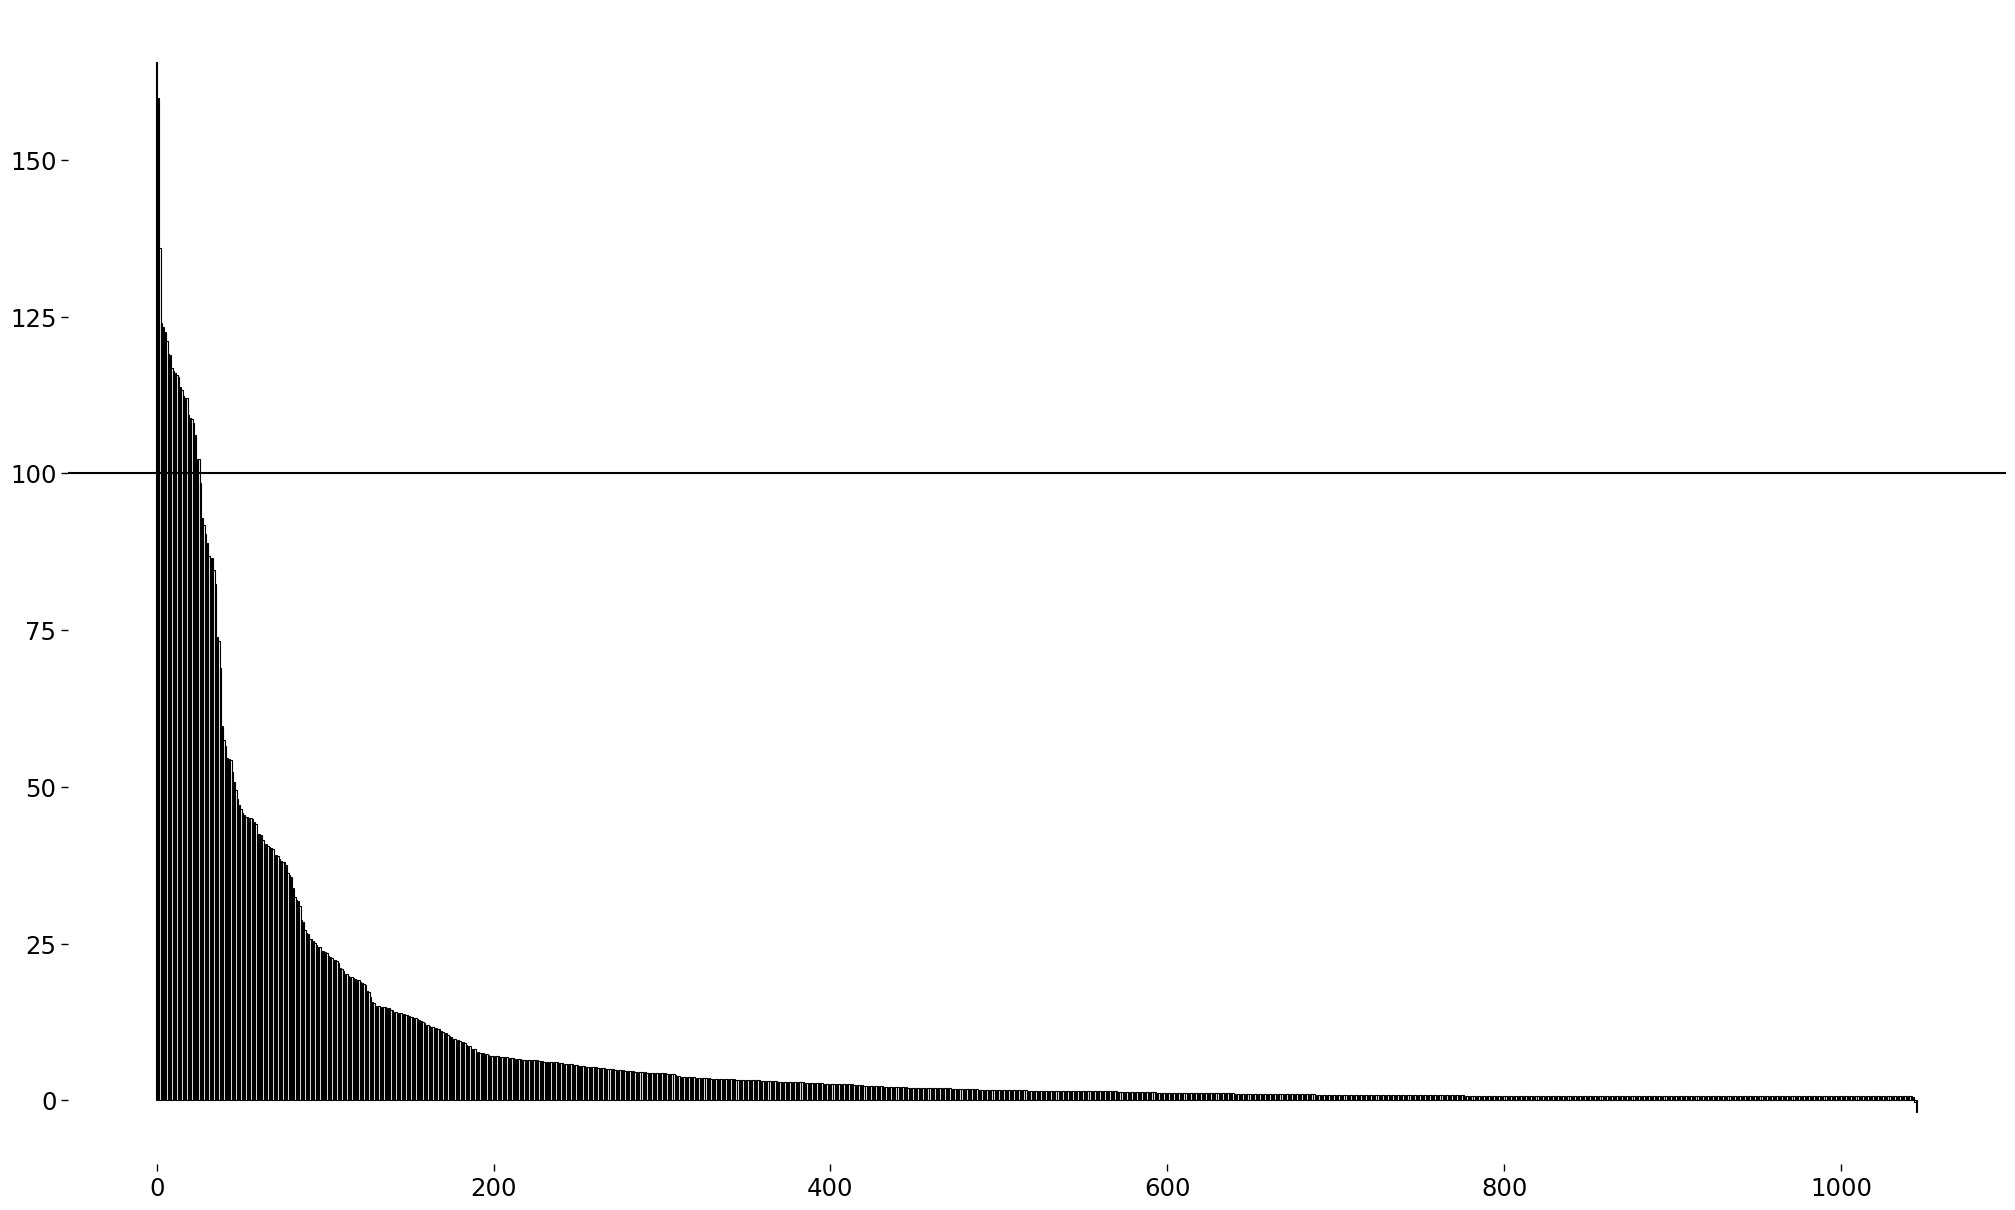

In [46]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y)

In [47]:
df_with_genotypes = pd.read_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round/top_ML_predicted_after_second_DBTL_2nd_analytics.csv')

In [48]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [49]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production,names
0,Smus,ENO2,CCW12,Clo,165.616468,Smus-ENO2_CCW12_Clo
1,Smus,ENO2,CCW12,Ara,159.805448,Smus-ENO2_CCW12_Ara
2,Vmin,ENO2,TPI1,Aan,135.953049,Vmin-ENO2_TPI1_Aan
3,Smus,ENO2,TPI1,Clo,123.920946,Smus-ENO2_TPI1_Clo
4,Smus,ENO2,TPI1,Cac,123.397377,Smus-ENO2_TPI1_Cac
...,...,...,...,...,...,...
1041,Ccal,RPL15B,URE2,Cpo,0.682537,Ccal-RPL15B_URE2_Cpo
1042,Vmin,ENO2,MLS1,Aan,0.666353,Vmin-ENO2_MLS1_Aan
1043,Cacu,ENO2,TPI1,Ara,0.523474,Cacu-ENO2_TPI1_Ara
1044,Rsep,ENO2,CCW12,Ahu,-0.272326,Rsep-ENO2_CCW12_Ahu


In [50]:
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

In [51]:
from constrain.plotting.plotting import horisontal_bar_plot

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


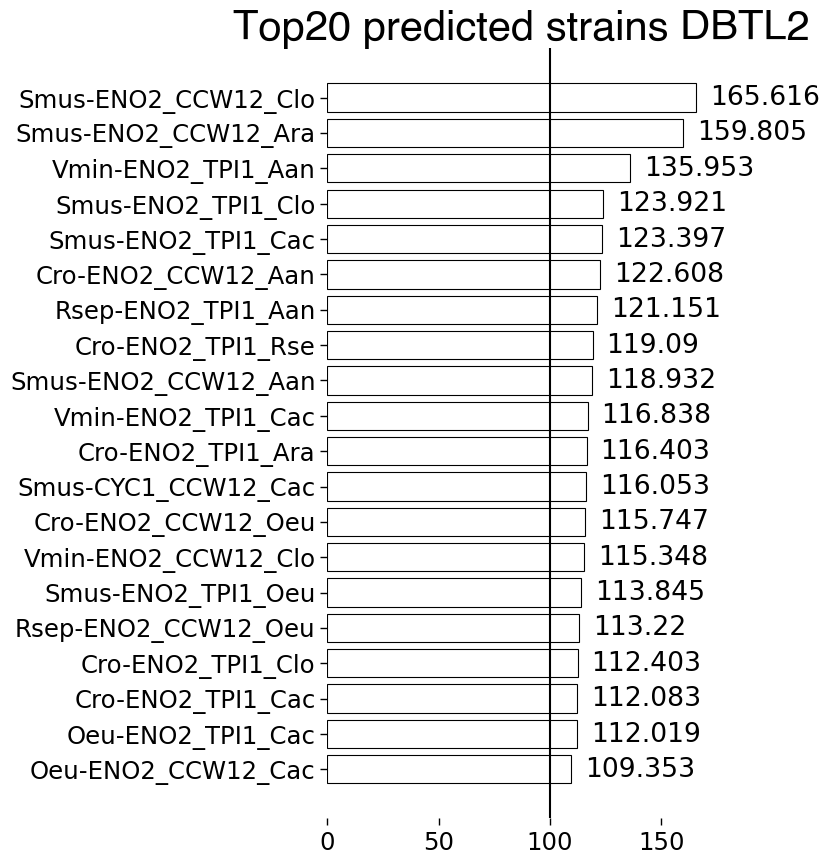

In [52]:
horisontal_bar_plot(x_axis,y_axis,  path = 'G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/Top20_predicted_strains_ML2', 
                    title = 'Top20 predicted strains DBTL2', 
                   size_height=5, 
                   size_length=10)

### 5.1 How many genotypes are predicted to produce more than the control strain?

In [53]:
over_100_strict_procduction = df_with_genotypes[df_with_genotypes['Predicted_strict_production'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(df_with_genotypes)} showed production of strictosidine over the normalized value")
print(f"Out of the remaing theoretical space these constittue : {(len(over_100_strict_procduction)/len(df_with_genotypes))*100}%")

26 strains out of 1046 showed production of strictosidine over the normalized value
Out of the remaing theoretical space these constittue : 2.48565965583174%


### 5.2 How well does the model predict on the old library i.e. 1121? Do we get the same genotypes when sorting for the best as the the first model? 

In [54]:
all_genotypes_1121 = pd.read_csv('G8H_CPR_library/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_first_iteration.csv', index_col= False)
all_genotypes =all_genotypes_1121[['0','1','2','3']]
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))

# Predict
predicted = best_model.predict(all_genotypes_df)

# make to dataframe
predicted_norm = predicted.as_data_frame()

# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
all_genotypes_1121['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = all_genotypes_1121.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted.to_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round_model_on_old_library/top_predictions_by_second_round_model_on_data_from_the_first_round.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [55]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

In [56]:
ML2_recomendations = pd.DataFrame(list_of_lists )
ML2_recomendations = ML2_recomendations.T

ML2_recomendations.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
ML2_recomendations100 = ML2_recomendations[:100]

In [57]:
# what it recomended in first round 
ML1_recomendations = pd.read_csv('G8H_CPR_library/data/09-AutoML/all_predictions/first_round/top_ML_predicted_after_first_DBTL_merged_analytics.csv')
ML1_recomendations100 = ML1_recomendations[0:100]
ML1_recomendations100['G8H'] = ML1_recomendations100['G8H']+'G8H'
ML1_recomendations100['CPR'] = ML1_recomendations100['CPR']+'CPR'

ML1_recomendations100

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4375/839636308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML1_recomendations100['G8H'] = ML1_recomendations100['G8H']+'G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4375/839636308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML1_recomendations100['CPR'] = ML1_recomendations100['CPR']+'CPR'


,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,SmusG8H,ENO2,TPI1,CroCPR,226.138557
1,SmusG8H,ENO2,TPI1,CloCPR,210.261962
2,SmusG8H,ENO2,TPI1,CacCPR,205.359575
3,SmusG8H,ENO2,TPI1,AanCPR,204.539731
4,RsepG8H,ENO2,TPI1,CroCPR,193.218189
...,...,...,...,...,...
95,OpumG8H,ENO2,TPI1,RseCPR,44.912977
96,VminG8H,CYC1,TPI1,AanCPR,44.517995
97,SmusG8H,RPL15B,TPI1,CacCPR,44.365785
98,SmusG8H,ENO2,URE2,OeuCPR,44.162532


In [58]:
ML1_recomendations100 = ML1_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100 = ML2_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100

,G8H,pG8H,pCPR,CPR
0,SmusG8H,ENO2,CCW12,CloCPR
1,SmusG8H,ENO2,CCW12,AraCPR
2,SmusG8H,ENO2,CCW12,CroCPR
3,VminG8H,ENO2,TPI1,AanCPR
4,OeuG8H,ENO2,TPI1,AanCPR
...,...,...,...,...
95,CroG8H,CYC1,CCW12,RseCPR
96,RsepG8H,CYC1,TPI1,OeuCPR
97,CroG8H,ENO2,URE2,AanCPR
98,OpumG8H,ENO2,TPI1,AraCPR


In [59]:
comparison = ML1_recomendations100.compare(ML2_recomendations100, keep_shape=True, keep_equal=True)
comparison

G8H             pG8H        pCPR            CPR        
       self    other    self other  self  other    self   other
0   SmusG8H  SmusG8H    ENO2  ENO2  TPI1  CCW12  CroCPR  CloCPR
1   SmusG8H  SmusG8H    ENO2  ENO2  TPI1  CCW12  CloCPR  AraCPR
2   SmusG8H  SmusG8H    ENO2  ENO2  TPI1  CCW12  CacCPR  CroCPR
3   SmusG8H  VminG8H    ENO2  ENO2  TPI1   TPI1  AanCPR  AanCPR
4   RsepG8H   OeuG8H    ENO2  ENO2  TPI1   TPI1  CroCPR  AanCPR
..      ...      ...     ...   ...   ...    ...     ...     ...
95  OpumG8H   CroG8H    ENO2  CYC1  TPI1  CCW12  RseCPR  RseCPR
96  VminG8H  RsepG8H    CYC1  CYC1  TPI1   TPI1  AanCPR  OeuCPR
97  SmusG8H   CroG8H  RPL15B  ENO2  TPI1   URE2  CacCPR  AanCPR
98  SmusG8H  OpumG8H    ENO2  ENO2  URE2   TPI1  OeuCPR  AraCPR
99  OpumG8H  VminG8H    ENO2  ENO2  TPI1   URE2  AanCPR  CacCPR

[100 rows x 8 columns]

In [60]:
comparison.to_csv('G8H_CPR_library/data/09-AutoML/all_predictions/second_round_model_on_old_library/ML1_top_predicted_vs_ML2_top100_predicted.csv')

In [61]:
difference = pd.concat([ML1_recomendations100,ML2_recomendations100]).drop_duplicates(keep=False)
the_same_rows = len(ML1_recomendations100) -len(difference)

In [62]:
print(f'The top predictions from the ML model in the second dbtl are share by the first round by {the_same_rows/len(ML1_recomendations100)*100}%')

The top predictions from the ML model in the second dbtl are share by the first round by 64.0%


### 5.3 Plotting the top predictions 

In [63]:
from constrain.plotting.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::6][::-1]
print(len(pcpr_color))
g8H_color= color_range_dict()['blue'][::3][::-1]
print(len(g8H_color))
pg8h_color = color_range_dict()['green'][::5][::-1]
print(len(pg8h_color))

10
4
8
4


In [64]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
pg8h_list_of_index = ["CYC1", "ENO2","PCK1","RPL15B"]
pcpr_list_of_index = ["CCW12", "TPI1","MLS1","URE2"]
all_parts = g8h_list_of_index + pg8h_list_of_index+pcpr_list_of_index+cpr_list_of_index

G8H_color_codes = dict(zip(g8h_list_of_index, g8H_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)

In [65]:
from constrain.plotting.plotting import carpet_barplot

26


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


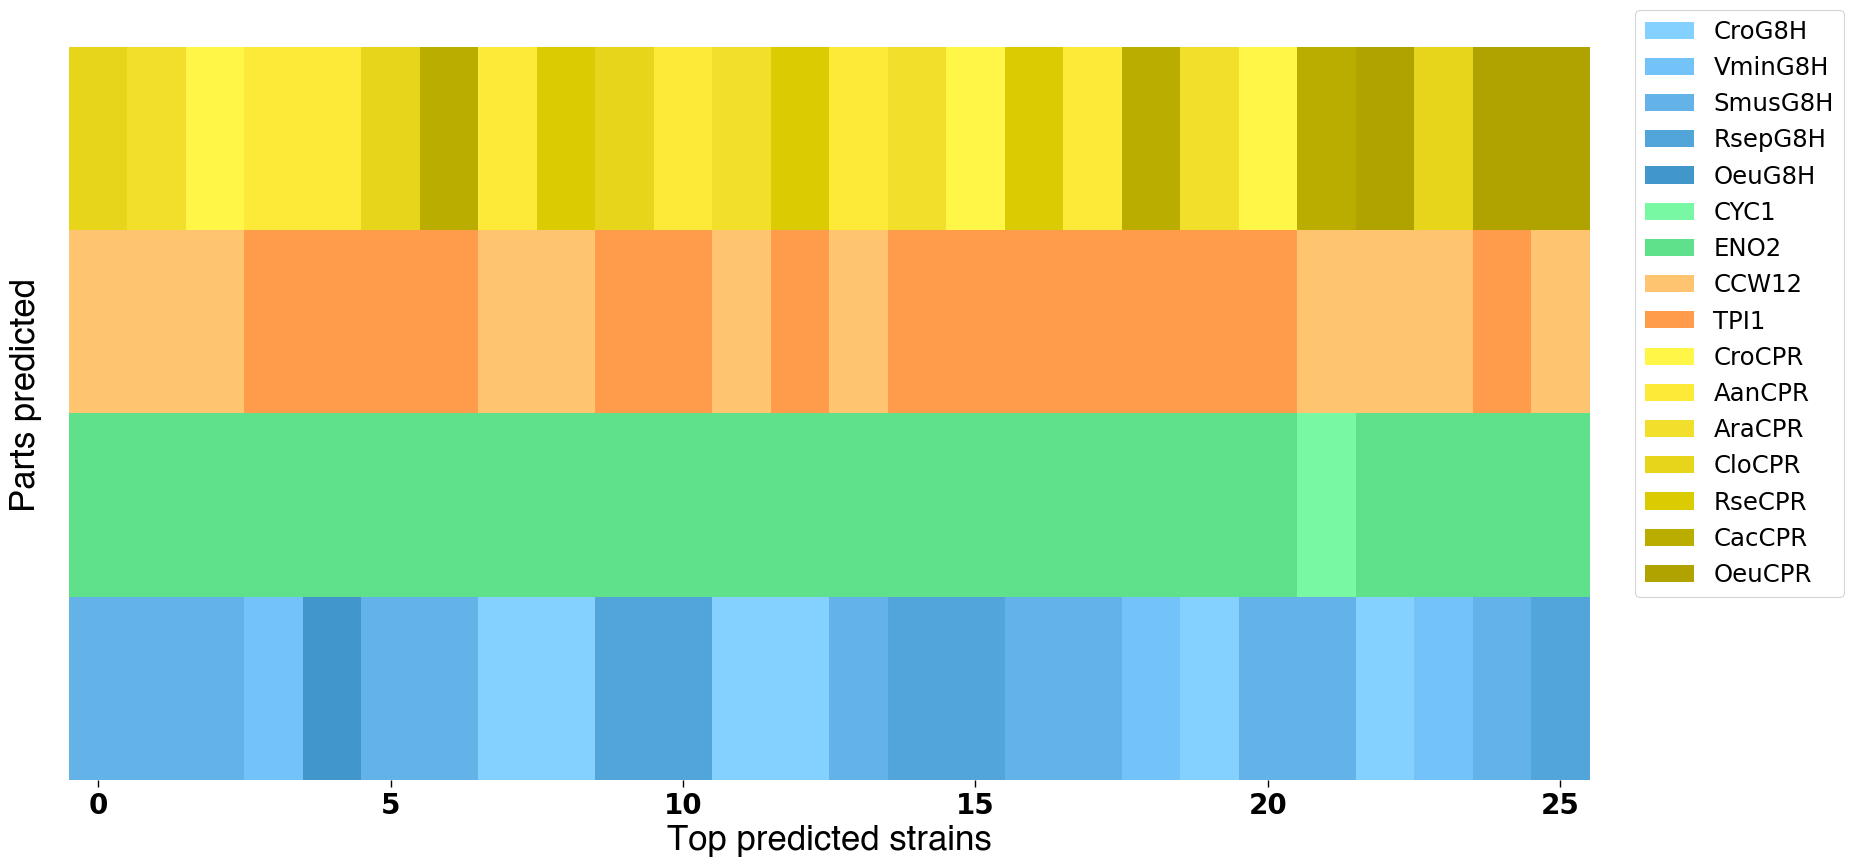

In [66]:
ML2_recomendations100['Index'] = ML2_recomendations100.index
list_of_parts = []
parst_index = []

for index, row in ML2_recomendations100.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)

d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

# slice df
df200 = df2[:104]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])

coloumns = list(cross_tab_prop.columns)


print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

name = 'Best_combinations_predicted_by_the_ML2_26_'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 



## 6. Learning curve on data

In [67]:
from constrain.machine_learning.auto_ml import autoML_on_partitioned_data

In [68]:
new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.922793
1,yp49_C01,1,2,5,9,0.509123
2,yp49_D01,2,4,7,3,0.166871
3,yp49_E01,2,1,5,7,0.327489
4,yp49_F01,3,3,6,1,25.060934
...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951
125,yp54_C04,5,2,6,3,94.318358
126,yp54_C09,3,1,6,3,46.469517
127,yp54_D12,5,1,6,6,3.718051


To make sure we dont see the experimental differences between the different runs we can shuffle the data (see below)

In [69]:
shuffled_new_input_for_ml = new_input_for_ml.sample(frac=1, random_state= 1).reset_index(drop=True) # Random state sets a seed on the shuffeling
shuffled_new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp54_A02,4,1,5,1,24.109070
1,yp53_E11,7,1,5,5,1.698060
2,yp54_F03,7,2,5,7,2.560352
3,yp53_F09,6,1,5,7,1.835963
4,yp54_A05,5,2,6,1,113.173462
...,...,...,...,...,...,...
291,yp53_D06,4,2,6,5,109.324769
292,yp54_B11,4,1,6,3,6.373347
293,yp50_C03,4,2,6,9,57.053306
294,yp53_E01,6,1,5,5,41.803421


This function takes 20+ hours to run. 

In [70]:
#feature_cols = ['0', '1', '2', '3']
#training_column = 'Amt_norm'
#
## Training 5 partitions 3 times - the function is set to nfold = 10  by default. 
#for i in range(0,3): 
#    autoML_on_partitioned_data(feature_cols, training_column,
#                               shuffled_new_input_for_ml,
#                               training_time=0, 
#                               partitions = 5,
#                               nfold= 10,
#                               path = '/Users/lucaslevassor/projects/ConStrain/colab_notebooks/G8H_CPR_library/data/09-AutoML/learning_curve_data/second_round/nfold_10/0sec_experiment/shuffled_random1/')

### 6.1 - Visiualizing the learning curve

In [71]:
import os

# folder path
dir_path = 'G8H_CPR_library/data/09-AutoML/learning_curve_data/second_round/nfold_10/0sec_experiment/shuffled_random1/'

# list file and directories
res = os.listdir(dir_path)
res

['.DS_Store',
 '2023_01_11_10:06_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_08_10:55_ml_models_running_over_partioned_data_df2_df1.csv',
 '2023_01_08_19:43_ml_models_running_over_partioned_data_df2_df1.csv',
 '2023_01_11_15:04_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_11_05:14_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_09_00:37_ml_models_running_over_partioned_data_df2_df1.csv']

In [72]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [73]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes[3:]]
concated = pd.concat(dfs, axis=1)
concated

,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name
Unnamed: 0,,,,,,,,,,,,
60,20.265256,24.947948,11.087297,XGBoost_lr_search_selection_AutoML_26_20230111_100602_select_grid_...,16.737130,20.445763,11.993407,StackedEnsemble_BestOfFamily_6_AutoML_16_20230111_02211,7.428000,14.660718,7.493557,StackedEnsemble_BestOfFamily_7_AutoML_26_20230108_194345
120,12.279735,18.538673,6.700190,StackedEnsemble_AllModels_5_AutoML_28_20230111_110434,12.173079,17.226658,9.652630,XGBoost_lr_search_selection_AutoML_17_20230111_12015_select_grid_m...,6.358275,12.685257,8.597869,XGBoost_lr_search_selection_AutoML_27_20230108_204253_select_grid_...
180,10.961404,16.290192,4.917861,StackedEnsemble_BestOfFamily_7_AutoML_30_20230111_120341,11.479273,14.279459,5.249099,StackedEnsemble_BestOfFamily_6_AutoML_18_20230111_21728,9.702213,12.834663,4.162396,StackedEnsemble_AllModels_5_AutoML_28_20230108_214057
240,10.178009,15.006841,6.094630,GBM_grid_1_AutoML_32_20230111_130319_model_12,10.178009,15.006841,6.094630,GBM_grid_1_AutoML_19_20230111_31558_model_12,8.611914,12.872042,3.526086,XGBoost_lr_search_selection_AutoML_29_20230108_223948_select_grid_...
296,10.048070,14.349804,4.571663,GBM_grid_1_AutoML_34_20230111_140339_model_12,10.119082,14.098402,4.570198,GBM_lr_annealing_selection_AutoML_20_20230111_41502_select_model,9.448801,12.660960,3.520006,XGBoost_lr_search_selection_AutoML_30_20230108_233835_select_grid_...


In [74]:

# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4375/2914699888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['mean'] = test_results.mean(axis=1)
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4375/2914699888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['std'] = test_results.std(axis=1)


,0,0,0,mean,std
Unnamed: 0,,,,,
60,20.265256,16.737130,7.428000,14.810129,5.415028
120,12.279735,12.173079,6.358275,10.270363,2.766606
180,10.961404,11.479273,9.702213,10.714297,0.746227
240,10.178009,10.178009,8.611914,9.655977,0.738264
296,10.048070,10.119082,9.448801,9.871984,0.300637


In [75]:

# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4375/1005275068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results['mean'] = cross_validated_results.mean(axis=1)


,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,mean
Unnamed: 0,,,,
60,24.947948,20.445763,14.660718,20.018143
120,18.538673,17.226658,12.685257,16.150196
180,16.290192,14.279459,12.834663,14.468105
240,15.006841,15.006841,12.872042,14.295241
296,14.349804,14.098402,12.660960,13.703055


In [76]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4375/3504483626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)


,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,mean
Unnamed: 0,,,,
60,11.087297,11.993407,7.493557,10.191420
120,6.700190,9.652630,8.597869,8.316896
180,4.917861,5.249099,4.162396,4.776452
240,6.094630,6.094630,3.526086,5.238449
296,4.571663,4.570198,3.520006,4.220622


In [77]:
from constrain.plotting.plotting import plot_ml_learning_curve

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


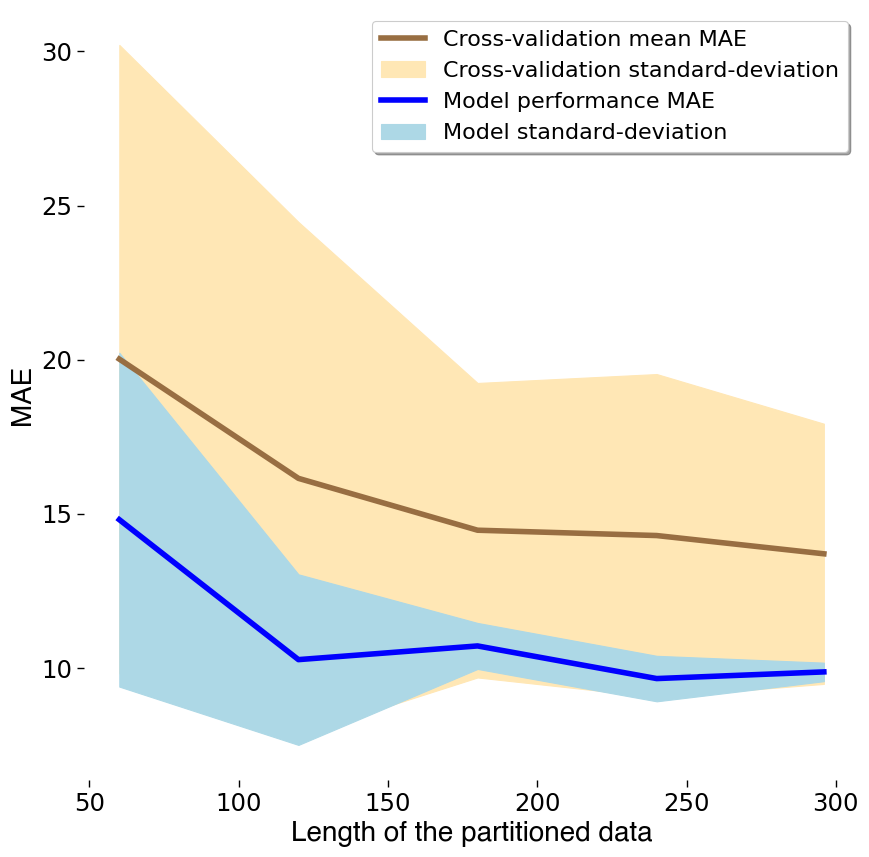

In [82]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  np.array(list(cross_validated_results_sd['mean']))

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))

plot = plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True , 
                              path = 'G8H_CPR_library/data/10-plots/11_2_LEARN_Data_analysis/Learning_curve_on_partitioned_data_DBTL2_10_height_10_length.pdf', 
                             size_height = 10,
                             size_length = 10, 
                             linewidth=4)

In [ ]:
h2o.shutdown()